# Cluster datapoints and visualize them
For each trajectory there is one datapoint with the averaged data, e.g., the average amount of water vapor, sensitivity, etc. \
Only the ascent and 2h before and after the ascent are considered. \
If the x-axis and y-axis are the same, a histogram is plotted.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=RuntimeWarning)

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import xarray as xr

from scripts.latexify import param_id_map
from scripts.cluster_data import *

pn.extension()

## Preparing data
This needs to be done once and can be skipped later if the averaged data is stored to disk. \
We already did it for the given configuration, therefore it is all a comment.

In [2]:
# cluster_var = [
#     'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
#     'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
#     'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
#     'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
#     'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
#     'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
#     'w', 'QV', 'latent_heat', 'latent_cool', 'lon', 'lat', 'relative_lon',
#     'relative_lat',
# ]
# data = load_data(
#     file_path="/media/mahieron/Austausch/data/Z2_data_gradients_02Nov/",
#     x=cluster_var, # The columns that will be available for clustering.
#     only_asc600=False,
#     inoutflow_time=240,
#     averages=True,
#     verbose=True,
# )

# comp = dict(zlib=True, complevel=9)
# encoding = {var: comp for var in data.data_vars}
# data.to_netcdf(
#     path="/media/mahieron/Austausch/data/Z2_data_stats/updated_flow_averaged_data_new.nc",
#     encoding=encoding,
#     compute=True,
#     engine="netcdf4",
#     format="NETCDF4",
#     mode="w",
# )

## Using data from all phases
But still only using time steps within the ascent and 2 hours of inflow and outflow each.
The datasets starting with 'updated' are new datasets supercede any other. \
'flow' indicates that time steps within the ascent and in- and outlflow are used. \
'asc600' is for datasets that use only ascent time steps but no flow. \
If neither 'flow' nor 'asc600' are in the name, then all time steps had been used.

In [2]:
# Loading the data
data = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/updated_flow_averaged_data.nc",
    decode_times=False,
    engine="netcdf4",
)
data

<xarray.Dataset>
Dimensions:              (Output_Parameter_ID: 3, trajectory: 1113,
                          ensemble: 1, file: 44)
Coordinates:
  * Output_Parameter_ID  (Output_Parameter_ID) uint64 6 22 23
  * trajectory           (trajectory) uint64 0 1 2 3 4 ... 1109 1110 1111 1112
  * ensemble             (ensemble) uint64 0
  * file                 (file) object 'Z2_wcb_trajs_20161003_19.nc' ... 'Z2_...
Data variables: (12/40)
    da_prime             (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    dk_1_conv            (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    dcloud_max_x         (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    dT_mult_min          (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    dgraupel_b_vel       (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    dhande_ccn_fac       (file, Output_Parameter_ID, ensemble, trajectory) float32 ...
    ...                   ...
    latent_heat          (file, ensemble, trajectory) float32 ...
    latent_cool          (file, ensemble, trajectory) float32 ...
    lon                  (file, ensemble, trajectory) float32 ...
    lat                  (file, ensemble, trajectory) float32 ...
    relative_lon         (file, ensemble, trajectory) float64 ...
    relative_lat         (file, ensemble, trajectory) float64 ...
Attributes:
    time:     2016-10-03T19:00:00.000

In [3]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
cluster_var = ['w']
verbose = True
# Set the following to true if you want to use all available columns
# for plotting on the x- or y-axis.
# If false, only variables used for clustering, cluster, file, and
# trajectory will be available.
include_all_data = True 
clusters = get_cluster(
    data=data,
    k=k,
    x=cluster_var,
    param_names=None, # sens_model_states,
    include_all_data=include_all_data,
    verbose=verbose,
)

Calculate the cluster


  0%|          | 0/43 [00:00<?, ?it/s]

Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=5, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
        [2] Toggle(button_type='success', name='Latexify')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
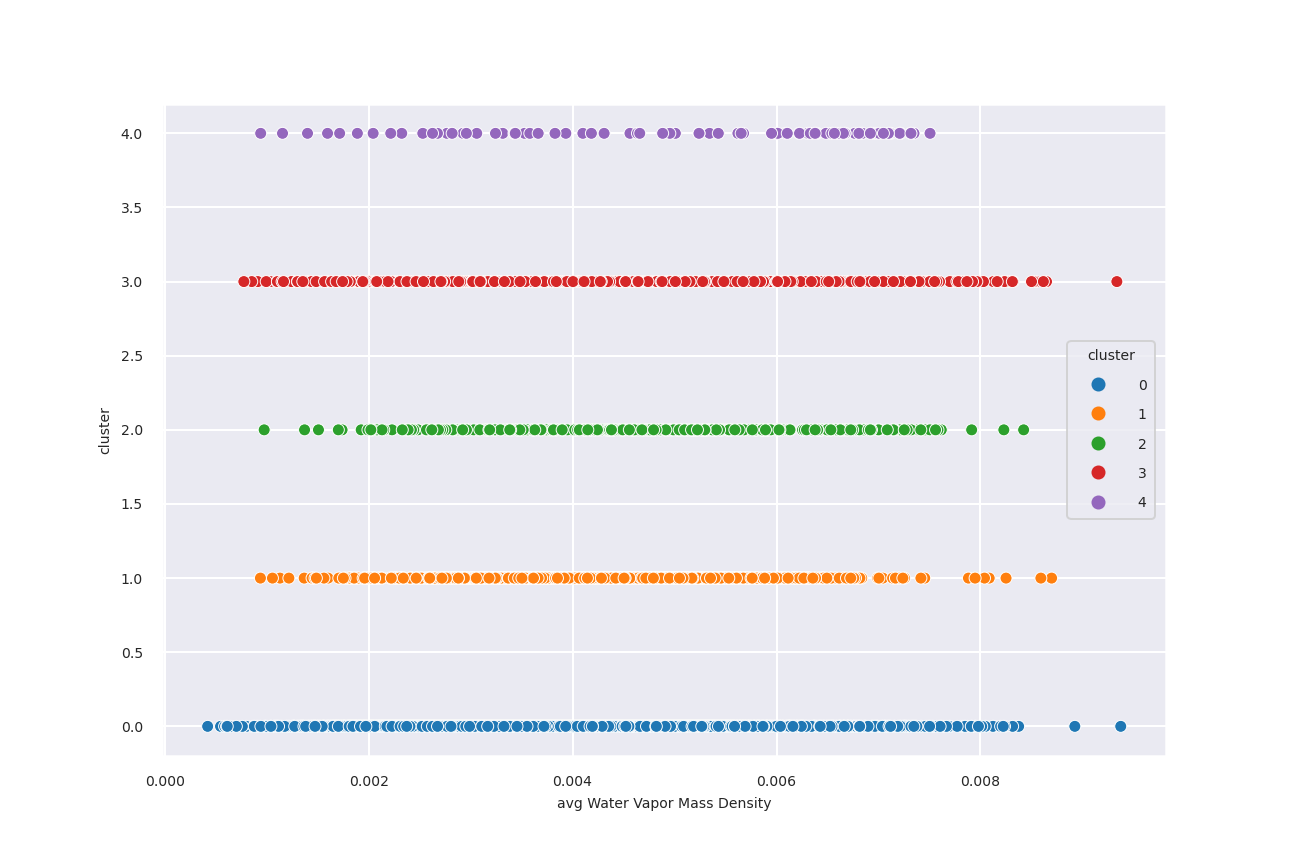

In [4]:
plot_cluster_data_interactive(clusters)

## Using data solely from the warm phase
The name for phases are appended to the dataset. \
Possible names are: \
warm_phase \
mixed_phase \
ice_phase

In [2]:
data_warm = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/updated_flow_averaged_data_warm_phase.nc",
    decode_times=False,
    engine="netcdf4",
)

In [3]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
verbose = True

In [4]:
clusters_warm = get_cluster(
    data=data_warm,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    include_all_data=include_all_data,
    verbose=verbose,
)

Calculate the cluster


Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
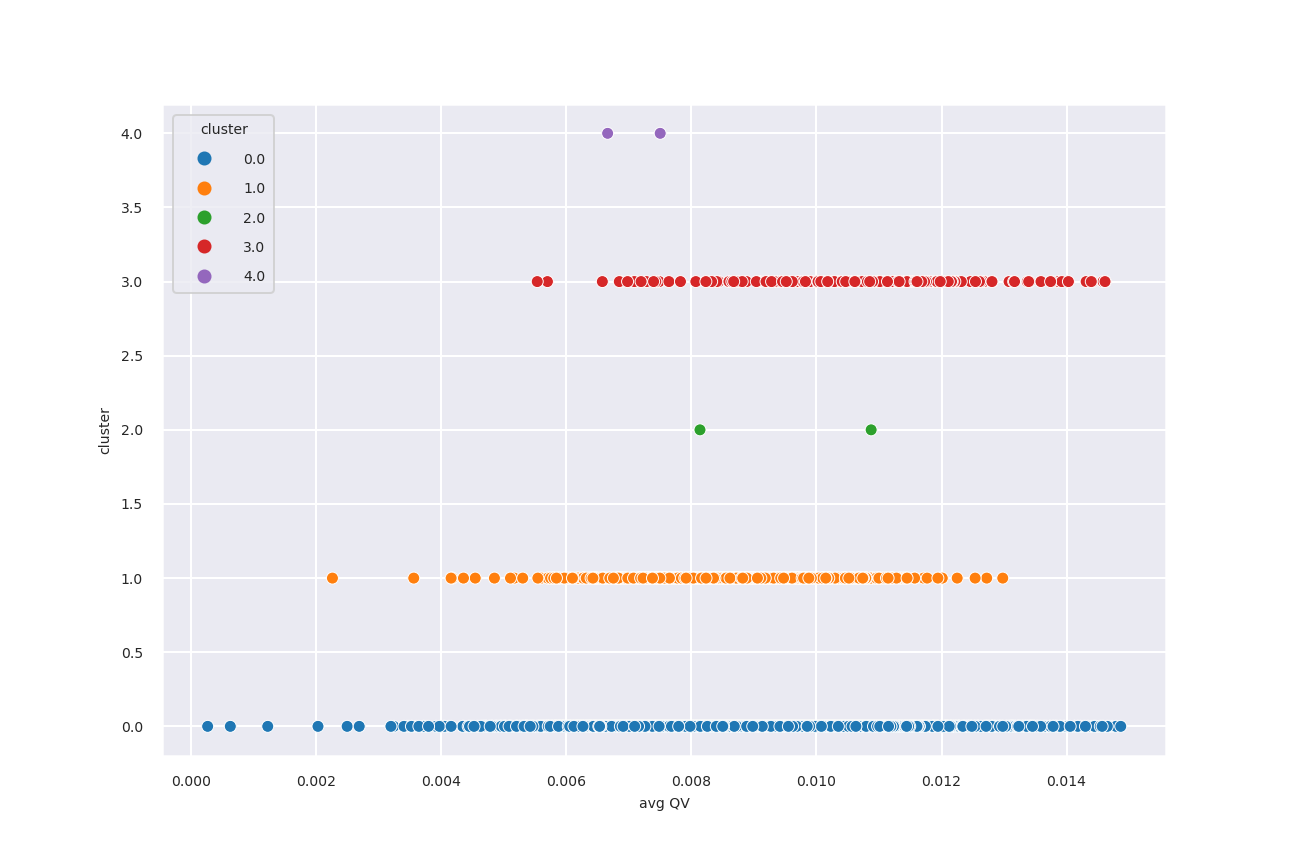

In [5]:
plot_cluster_data_interactive(clusters_warm)

## Using data solely from the mixed phase

In [10]:
data_mixed = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/updated_flow_averaged_data_mixed_phase.nc",
    decode_times=False,
    engine="netcdf4",
)

In [11]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
verbose = True

In [12]:
clusters_mixed = get_cluster(
    data=data_mixed,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    include_all_data=include_all_data,
    verbose=verbose,
)

Calculate the cluster


Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
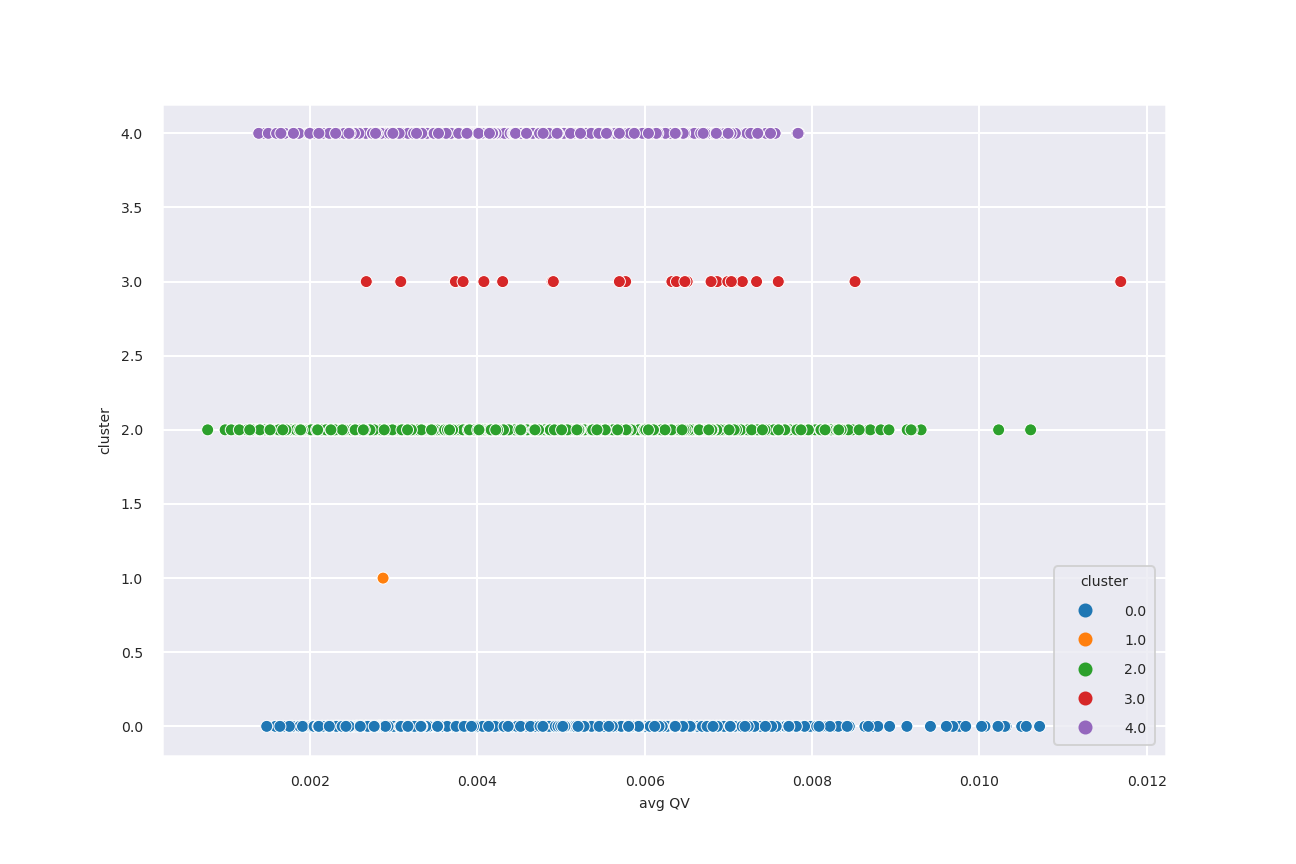

In [13]:
plot_cluster_data_interactive(clusters_mixed)